In [ ]:
!pip install fair-esm
!pip install nvidia-ml-py3


In [ ]:
!pip install "fair-esm[esmfold]"
# OpenFold and its remaining dependency
!pip install 'dllogger @ git+https://github.com/NVIDIA/dllogger.git'
!pip install 'openfold @ git+https://github.com/aqlaboratory/openfold.git@4b41059694619831a7db195b7e0988fc4ff3a307'

In [ ]:
!pip install MDAnalysis

In [ ]:
!pip install torch-geometric

In [1]:
import pandas as pd
import numpy as np
import torch
import esm
from tqdm import tqdm
import gc
import time
import nvidia_smi
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from Bio.PDB import PDBParser, NeighborSearch
from concurrent.futures import ThreadPoolExecutor
import warnings
from Bio import BiopythonWarning

import MDAnalysis as mda
from MDAnalysis.analysis import distances

import _pickle as cPickle

In [2]:
df = pd.read_csv("cafa3.csv", index_col = 0)
df = df[df["go_class"] == "C"]

In [3]:
df["seq"] = df["seq"].apply(lambda x: x.replace("X", "A"))

In [4]:
df = df[df["seq"].str.len() < 301]

In [5]:
#df.head()

In [6]:
proteins = df.drop_duplicates("id", ignore_index = True)[["id", "seq"]]

In [7]:
proteins_array = proteins.to_numpy()

In [8]:
len(proteins_array)

15292

In [89]:
proteins_array_test = proteins_array[20:40]

In [8]:
# Load ESM-1b model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

In [9]:
unique_protein_ids = df['id'].unique();
batch_converter = alphabet.get_batch_converter();
# Use GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");

model.to(device);

model.eval();

In [ ]:
#sequence_representations_copy = sequence_representations

In [10]:
err_counter = 0
residue_representations = {}
sequence_representations = {}
#len(proteins_array)

for i in tqdm(range(0,len(proteins_array), 1)):
    batch = proteins_array[i:i+1]

    batch_labels, batch_strs, batch_tokens = batch_converter(batch)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(device)

    try:
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[6])

    except:
        print("Could not load", batch_labels, "into memory")
        err_counter += 1
        torch.cuda.empty_cache()
        del batch_tokens
        continue
        
    results = {
    key: {nested_key: value.detach().to('cpu') for nested_key, value in nested_dict.items()}
    if isinstance(nested_dict, dict)
    else nested_dict.detach().to('cpu')
    for key, nested_dict in results.items()
    }
    
    token_representations = results["representations"][6].detach().cpu()

    for j, tokens_len in enumerate(batch_lens):
        residue_representations[batch_labels[j]] = token_representations[j, 1:tokens_len - 1].numpy()
        sequence_representations[batch_labels[j]] = token_representations[j, 1:tokens_len - 1].mean(0).numpy()

    batch_tokens = batch_tokens.detach().to('cpu')

    del batch_labels, batch_strs, batch_tokens, batch_lens, results, token_representations

    # Clear GPU cache and sleep
    
    torch.cuda.empty_cache()

    nvidia_smi.nvmlInit()
    
    if (i % 5000) == 0:

        deviceCount = nvidia_smi.nvmlDeviceGetCount()
        for i in range(deviceCount):
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

        nvidia_smi.nvmlShutdown()
    #time.sleep(1)

  0%|          | 19/15292 [00:00<07:01, 36.26it/s] 

Device 0: b'Tesla V100-SXM2-16GB', Memory : (92.46% free): 17179869184(total), 15884812288 (free), 1295056896 (used)


 33%|███▎      | 5018/15292 [00:55<01:52, 91.43it/s] 

Device 0: b'Tesla V100-SXM2-16GB', Memory : (92.46% free): 17179869184(total), 15884812288 (free), 1295056896 (used)


 66%|██████▌   | 10017/15292 [01:51<00:53, 98.65it/s] 

Device 0: b'Tesla V100-SXM2-16GB', Memory : (92.46% free): 17179869184(total), 15884812288 (free), 1295056896 (used)


 98%|█████████▊| 15017/15292 [02:46<00:03, 89.40it/s] 

Device 0: b'Tesla V100-SXM2-16GB', Memory : (92.46% free): 17179869184(total), 15884812288 (free), 1295056896 (used)


100%|██████████| 15292/15292 [02:49<00:00, 90.08it/s]


In [93]:

# with open('residue_representations.pkl', 'wb') as f:
#     cPickle.dump(residue_representations, f, protocol=-1)

In [341]:
%system free -m

['              total        used        free      shared  buff/cache   available',
 'Mem:          52328       18576       17284          33       16467       33105',
 'Swap:             0           0           0']

In [ ]:
!nvidia-smi

In [36]:
torch.cuda.empty_cache()

# ML

In [ ]:



# Define the models
models = [
    #('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    #('Linear SVC', LinearSVC()),
    ('Decision Tree', DecisionTreeClassifier())
]

# Train and test the models
for name, model in models:
    classifier = OneVsRestClassifier(model)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    print(f"{name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='micro'):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='micro'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='micro'):.4f}")
    print()

# Prediction with Embeddings

In [16]:
df_grouped = df.groupby(['id', 'seq'], as_index=False)['go_label'].agg(lambda x: list(x))

In [ ]:
small_embeddings = pd.DataFrame(sequence_representations)
small_embeddings = small_embeddings.T.reset_index().rename(columns = {'index' : 'id'})
small_embeddings["embedding"] = small_embeddings.iloc[:, 1:].values.tolist()
small_embeddings = small_embeddings[["id", "embedding"]]
df_grouped_small_embeddings = df_grouped.merge(small_embeddings, on = "id")

In [256]:
# Data for residue level embeddings
mlb = MultiLabelBinarizer()
X_small = np.array(list(df_grouped_small_embeddings["embedding"]))
y_small = mlb.fit_transform(df_grouped_small_embeddings["go_label"])
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.1, random_state=42)

In [257]:
# Data for residue level embeddings

In [260]:
#np.save('X_small_train_residues.npy', np.array(X_small_train_residues))

In [261]:
class ESM2Dataset(Dataset):
    def __init__(self, esm2_embeddings, go_labels):
        self.esm2_embeddings = esm2_embeddings
        self.go_labels = go_labels

    def __len__(self):
        return len(self.esm2_embeddings)

    def __getitem__(self, idx):
        return torch.tensor(self.esm2_embeddings[idx], dtype=torch.float32), torch.tensor(self.go_labels[idx], dtype=torch.float32)

# Create Dataset instances
train_dataset = ESM2Dataset(X_small_train, y_small_train)
val_dataset = ESM2Dataset(X_small_test, y_small_test)

# Create DataLoader instances
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [262]:
df_valid = df[df["id"].isin(df_grouped_small_embeddings.id.unique())]

In [263]:
df_valid.head()

,id,go_label,go_class,seq
0,P0DJZ0,GO:0030430,C,MQNNTTGMDTKSLKNCGQPKAVCTHCKHSPPCPQPGCVTKRPPVPP...
2,P83011,GO:0043231,C,MIFTAADRSAIEAV
3,P83010,GO:0043231,C,AGEPANNEDRFNY
5,P48347,GO:0005829,C,MENEREKQVYLAKLSEQTERYDEMVEAMKKVAQLDVELTVEERNLV...
6,P48347,GO:0005739,C,MENEREKQVYLAKLSEQTERYDEMVEAMKKVAQLDVELTVEERNLV...


In [264]:
go_label_value_counts = dict(df_valid.go_label.value_counts())
n_samples = df_valid.id.nunique()

In [265]:
pos_weights = []
for go_term in mlb.classes_:
    curr_count = float(go_label_value_counts[go_term])
    pos_weights.append((n_samples - curr_count)/curr_count)
weighted_pos_weights = torch.tensor(pos_weights)

In [266]:
weighted_pos_weights

tensor([15291.0000,  5096.3335,  2183.5715,  ..., 15291.0000,  5096.3335,
        15291.0000])

In [28]:
def accuracy(outputs, labels):
    # Assuming sigmoid activation function and threshold of 0.5 for multilabel classification
    predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
    correct = (predicted_labels == labels).sum().item()
    total = labels.numel()
    return correct / total

def positive_class_accuracy(outputs, labels):
    predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
    true_positives = (predicted_labels * labels).sum().item()
    total_positives = labels.sum().item()

    return true_positives / total_positives, total_positives


In [12]:
def positive_class_metrics(outputs, labels, threshold=0.5):
    with torch.no_grad():
        # Apply the sigmoid activation and threshold to get binary predictions
        predictions = (torch.sigmoid(outputs) > threshold).float()

        # Compute true positives, false positives, and false negatives
        true_positives = (predictions * labels).sum().item()
        false_positives = ((predictions - labels) > 0).float().sum().item()
        false_negatives = ((labels - predictions) > 0).float().sum().item()

        # Compute precision, recall, and F1-score for the positive class
        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

In [10]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.batch_norm3 = nn.BatchNorm1d(output_size)
        
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.fc3(x)
        x = self.batch_norm3(x)
        #x = self.softmax(x)
        return x

In [31]:
def positive_label_bce_loss(outputs, labels, positive_weight=100.0):
    # Apply sigmoid activation to the outputs
    #sigmoid_outputs = torch.sigmoid(outputs)

    # Compute BCE loss for each element
    elementwise_bce_loss = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none')

    # Create a mask for positive labels
    positive_label_mask = labels > 0

    # Create a mask for negative labels
    negative_label_mask = labels <= 0

    # Compute the loss for positive labels only
    positive_label_loss = elementwise_bce_loss * positive_label_mask.float()

    # Compute the loss for negative labels only
    negative_label_loss = elementwise_bce_loss * negative_label_mask.float()

    # Multiply the positive label loss by the positive weight factor
    positive_label_loss = positive_label_loss * positive_weight

    # Calculate the total weighted loss
    total_loss = positive_label_loss + negative_label_loss

    # Calculate the average loss
    avg_loss = total_loss.sum() / (positive_label_mask.sum().float() + negative_label_mask.sum().float())

    return avg_loss

In [193]:
next(iter(train_loader))[1].shape

torch.Size([64, 1185])

In [300]:
int(df.go_label.nunique() / 2)

670

In [305]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []



# Hyperparameters
input_size = 320
hidden_size = df.go_label.nunique()
hidden_size2 = int(df.go_label.nunique() / 2)
output_size = df.go_label.nunique()
learning_rate = 0.01
num_epochs = 50

# Instantiate the model, loss, and optimizer
model = MLP(input_size, hidden_size, hidden_size2, output_size).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = weighted_pos_weights.clone().detach().to(device)) # Assuming 'weighted_pos_weights' is a list containing the weights for each GO term pos_weight=weighted_pos_weights.clone().detach().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5)

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 5
early_stopping_counter = 0
best_model = None

# Training loop
for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    val_loss = 0
    val_correct = 0


    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader): # Assuming 'train_loader' is a DataLoader instance containing the training dataset
        data = data.float()
        labels = labels.float()

        data = data.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(data)
        
        #loss = criterion(outputs, labels)
        loss = positive_label_bce_loss(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        #print(accuracy(outputs, labels), data.size(0))
        
        #train_correct += accuracy(outputs, labels) * data.size(0)
        
        accuracy, total_positives = positive_class_accuracy(outputs, labels)

        # weighted_accuracy = (accuracies * total_positives).sum().item() / total_positives.sum().item()
        train_correct += accuracy * data.size(0)

 
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            #loss = criterion(outputs, labels)
            loss = positive_label_bce_loss(outputs, labels)
            
            val_loss += loss.item()
        
            #val_correct += accuracy(outputs, labels) * data.size(0)
            
            accuracy, total_positives = positive_class_accuracy(outputs, labels)
        
            # weighted_accuracy = (accuracies * total_positives).sum().item() / total_positives.sum().item()
            val_correct += accuracy * data.size(0)
            
       
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_correct / len(train_dataset))
    val_accuracies.append(val_correct / len(val_dataset))

    
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}, Val_Loss: {val_losses[-1]:.4f}, Val_Accuracy: {val_accuracies[-1]:.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}, Val_Loss: {val_losses[-1]:.4f}, Val_Accuracy: {val_accuracies[-1]:.4f}')
        
        
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        early_stopping_counter = 0
        best_model = model.state_dict()
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print("Early stopping")
            model.load_state_dict(best_model)
            break

Epoch [1/50], Loss: 0.3843, Accuracy: 0.3696, Val_Loss: 0.1847, Val_Accuracy: 0.3519
Epoch [2/50], Loss: 0.1261, Accuracy: 0.3543, Val_Loss: 0.0876, Val_Accuracy: 0.3936
Epoch [3/50], Loss: 0.0699, Accuracy: 0.3774, Val_Loss: 0.0566, Val_Accuracy: 0.3904
Epoch [4/50], Loss: 0.0488, Accuracy: 0.3900, Val_Loss: 0.0429, Val_Accuracy: 0.4097
Epoch [5/50], Loss: 0.0384, Accuracy: 0.4073, Val_Loss: 0.0353, Val_Accuracy: 0.4214
Epoch [6/50], Loss: 0.0323, Accuracy: 0.4246, Val_Loss: 0.0309, Val_Accuracy: 0.4203
Epoch [7/50], Loss: 0.0284, Accuracy: 0.4376, Val_Loss: 0.0280, Val_Accuracy: 0.4178
Epoch [8/50], Loss: 0.0256, Accuracy: 0.4491, Val_Loss: 0.0262, Val_Accuracy: 0.4364
Epoch [9/50], Loss: 0.0235, Accuracy: 0.4582, Val_Loss: 0.0249, Val_Accuracy: 0.4419
Epoch [10/50], Loss: 0.0217, Accuracy: 0.4726, Val_Loss: 0.0239, Val_Accuracy: 0.4420
Epoch [11/50], Loss: 0.0204, Accuracy: 0.4835, Val_Loss: 0.0231, Val_Accuracy: 0.4435
Epoch [12/50], Loss: 0.0190, Accuracy: 0.4963, Val_Loss: 0.0224

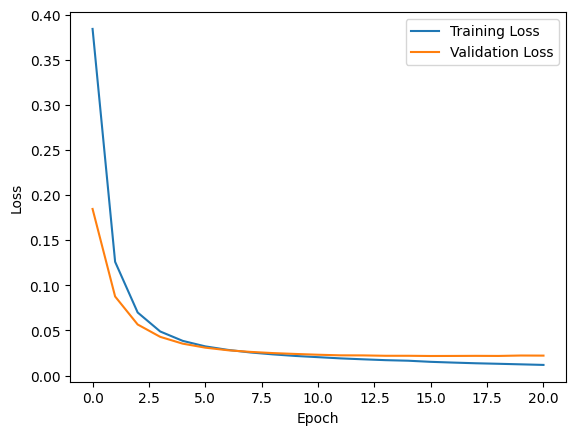

In [329]:
# Plot the loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

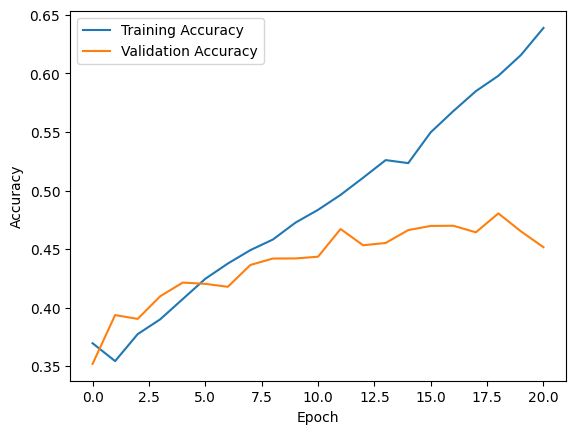

In [330]:
# Plot the accuracy curves
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [157]:
def predict(model, input_embedding, device, threshold=0.5):
    # Put the model in evaluation mode
    model.eval()

    # Convert the input embedding to a PyTorch tensor and reshape it
    input_tensor = torch.tensor(input_embedding, dtype=torch.float32).view(1, -1)

    # Move the input tensor to the device the model is on
    input_tensor = input_tensor.to(device)

    # Pass the input tensor through the model to get the output logits
    with torch.no_grad():
        output_logits = model(input_tensor)

    # Apply the sigmoid activation to the logits to get probabilities
    probabilities = torch.sigmoid(output_logits)

    # Apply the threshold to the probabilities to get the binary predictions
    predictions = (probabilities > threshold).float()

    return predictions.cpu().numpy()

In [174]:
input_embedding = X_small_test[5]  # Replace with your actual input embedding
predictions = predict(model, input_embedding, device)[0]


In [175]:
np.where(predictions == 1)


(array([132, 181, 242]),)

In [177]:
np.where(y_small_test[5] == 1)


(array([132, 242]),)

# CNN

In [268]:
class CNN(nn.Module):
    def __init__(self, num_go_terms):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)

        # Calculate input size for the first fully connected layer
        input_size = 64 * (320 // (2 * 2))

        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, num_go_terms)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        #x = self.sigmoid(x)
        return x

In [308]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses_cnn = []
val_losses_cnn = []
train_accuracies_cnn = []
val_accuracies_cnn = []

# Hyperparameters
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model, loss, and optimizer
cnn = CNN(output_size).to(device)
criterion = nn.BCEWithLogitsLoss() # Assuming 'weighted_pos_weights' is a list containing the weights for each GO term pos_weight=weighted_pos_weights.clone().detach().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate, weight_decay = 1e-5)

# Initialize variables for early stopping
best_val_loss_cnn = float('inf')
patience = 5
early_stopping_counter_cnn = 0
best_model_cnn = None

# Training loop
for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    train_neg_correct = 0
    val_loss = 0
    val_correct = 0
    val_neg_correct = 0

    cnn.train()
    for batch_idx, (data, labels) in enumerate(train_loader): # Assuming 'train_loader' is a DataLoader instance containing the training dataset
        data = data.float()
        labels = labels.float()

        data = data.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = cnn(data)
        #loss = criterion(outputs, labels)
        loss = positive_label_bce_loss(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        #train_correct += accuracy(outputs, labels) * data.size(0)
        
        accuracy, total_positives = positive_class_accuracy(outputs, labels)
        # weighted_accuracy = (accuracies * total_positives).sum().item() / total_positives.sum().item()
        train_correct += accuracy * data.size(0)


        #train_correct += positive_class_accuracy(outputs, labels) * data.size(0)

    cnn.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            data = data.to(device)
            labels = labels.to(device)

            outputs = cnn(data)
            #loss = criterion(outputs, labels)
            loss = positive_label_bce_loss(outputs, labels)
            
            val_loss += loss.item()
        
            #val_correct += accuracy(outputs, labels) * data.size(0)
            
            accuracy, total_positives = positive_class_accuracy(outputs, labels)
            # weighted_accuracy = (accuracies * total_positives).sum().item() / total_positives.sum().item()
            val_correct += accuracy * data.size(0)
            
            
            # val_correct += weighted_accuracy

            

    train_losses_cnn.append(train_loss / len(train_loader))
    val_losses_cnn.append(val_loss / len(val_loader))
    train_accuracies_cnn.append(train_correct / len(train_dataset))
    val_accuracies_cnn.append(val_correct / len(val_dataset))
    train_neg_accuracies_cnn.append(train_neg_correct / len(train_dataset))
    val_neg_accuracies_cnn.append(val_neg_correct / len(val_dataset))
            
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses_cnn[-1]:.4f}, Accuracy: {train_accuracies_cnn[-1]:.4f}, Val_Loss: {val_losses_cnn[-1]:.4f}, Val_Accuracy: {val_accuracies_cnn[-1]:.4f}')

    if val_losses_cnn[-1] < best_val_loss_cnn:
        best_val_loss_cnn = val_losses_cnn[-1]
        early_stopping_counter_cnn = 0
        best_model_cnn = cnn.state_dict()
    else:
        early_stopping_counter_cnn += 1
        print(f"Early stopping counter: {early_stopping_counter_cnn}/{patience}")
        if early_stopping_counter_cnn >= patience:
            print("Early stopping")
            cnn.load_state_dict(best_model_cnn)
            break

Epoch [1/100], Loss: 0.2855, Accuracy: 0.2379, Val_Loss: 0.0328, Val_Accuracy: 0.1996
Epoch [2/100], Loss: 0.0539, Accuracy: 0.2118, Val_Loss: 0.0301, Val_Accuracy: 0.2053
Epoch [3/100], Loss: 0.0421, Accuracy: 0.2166, Val_Loss: 0.0290, Val_Accuracy: 0.2004
Epoch [4/100], Loss: 0.0374, Accuracy: 0.2204, Val_Loss: 0.0274, Val_Accuracy: 0.2278
Epoch [5/100], Loss: 0.0349, Accuracy: 0.2276, Val_Loss: 0.0272, Val_Accuracy: 0.2200
Epoch [6/100], Loss: 0.0331, Accuracy: 0.2354, Val_Loss: 0.0269, Val_Accuracy: 0.2285
Epoch [7/100], Loss: 0.0322, Accuracy: 0.2403, Val_Loss: 0.0268, Val_Accuracy: 0.2454
Epoch [8/100], Loss: 0.0312, Accuracy: 0.2469, Val_Loss: 0.0259, Val_Accuracy: 0.2550
Epoch [9/100], Loss: 0.0305, Accuracy: 0.2564, Val_Loss: 0.0256, Val_Accuracy: 0.2750
Epoch [10/100], Loss: 0.0295, Accuracy: 0.2616, Val_Loss: 0.0257, Val_Accuracy: 0.2736
Early stopping counter: 1/5
Epoch [11/100], Loss: 0.0287, Accuracy: 0.2716, Val_Loss: 0.0252, Val_Accuracy: 0.2809
Epoch [12/100], Loss: 0.

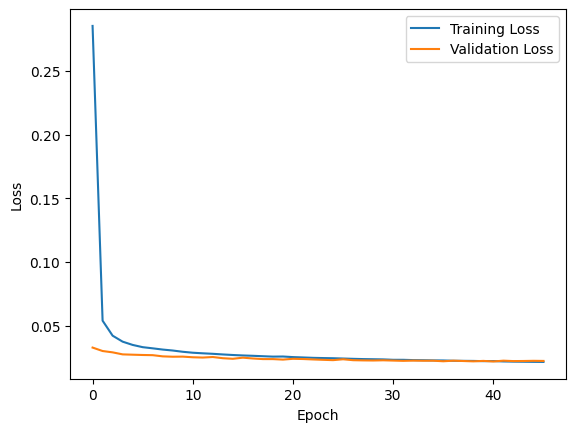

In [309]:
# Plot the loss curves
plt.plot(train_losses_cnn, label='Training Loss')
plt.plot(val_losses_cnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

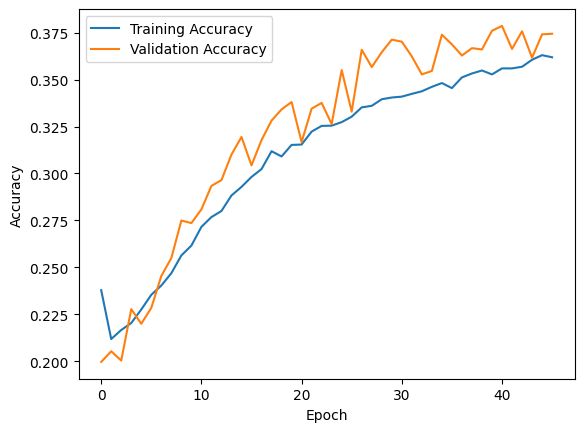

In [310]:
# Plot the accuracy curves
plt.plot(train_accuracies_cnn, label='Training Accuracy')
plt.plot(val_accuracies_cnn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [282]:
input_embedding = X_small_test[50]  # Replace with your actual input embedding
predictions = predict(cnn, input_embedding, device)[0]

print(np.where(predictions == 1))

print(np.where(y_small_test[5] == 1))

# Strucutre Prediction + Contact Maps

In [331]:
!pip --version

pip 23.0.1 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)


In [14]:
model = esm.pretrained.esmfold_v1()
model = model.eval().cuda()

In [15]:
# sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"
# # Multimer prediction can be done with chains separated by ':'

# with torch.no_grad():
#     output = model.infer_pdb(sequence)

In [16]:
def generate_contact_map_array(pdb_file, distance_cutoff= 10.0):
    # Load the PDB file
    u = mda.Universe(pdb_file)

    # Select all atoms
    res_com = u.atoms.center_of_mass(compound='residues')
    n_res = len(res_com)
    res_dist = distances.self_distance_array(res_com)
    sq_dist_res = np.zeros((n_res, n_res))
    triu = np.triu_indices_from(sq_dist_res, k=1)
    sq_dist_res[triu] = res_dist
    sq_dist_res.T[triu] = res_dist
    
    # Calculate the distance matrix
    distance_matrix = np.asarray(sq_dist_res)

    # Generate the contact map
    contact_map = np.where(distance_matrix <= distance_cutoff, 1, 0)

    # Set the diagonal to zero (no self-contacts)
    np.fill_diagonal(contact_map, 0)
    #return distance_matrix
    return contact_map

In [17]:
err_counter = 0

for i, protein in tqdm(enumerate(proteins_array[3000:])):

    prot_id = protein[0]
    seq = protein[1]
    
    try:
        with torch.no_grad():
            output = model.infer_pdb(seq)
    except:
        print("Could not load", prot_id, "into memory")
        err_counter += 1
        torch.cuda.empty_cache()
        continue
    
    torch.cuda.empty_cache()
    
    nvidia_smi.nvmlInit()
    
    if (i % 5000) == 0:

        deviceCount = nvidia_smi.nvmlDeviceGetCount()
        for i in range(deviceCount):
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

        nvidia_smi.nvmlShutdown()
        
    with open("result.pdb", "w") as f:
        f.write(output)
    
    # Read a PDB file and generate a contact map
    pdb_file = "result.pdb"
    contact_map = generate_contact_map_array(pdb_file);

    # Save the contact map to a file
    np.save(f"contact_maps/{str(prot_id)}.npy", contact_map)
    
    del output

1it [00:05,  5.77s/it]

Device 0: b'Tesla V100-SXM2-16GB', Memory : (41.41% free): 17179869184(total), 7114522624 (free), 10065346560 (used)


5001it [4:35:02,  2.95s/it]

Device 0: b'Tesla V100-SXM2-16GB', Memory : (41.39% free): 17179869184(total), 7110328320 (free), 10069540864 (used)


10001it [9:04:38,  1.35s/it]

Device 0: b'Tesla V100-SXM2-16GB', Memory : (41.35% free): 17179869184(total), 7104036864 (free), 10075832320 (used)


12292it [11:12:59,  3.28s/it]


In [ ]:
err_counter = 0

for i, protein in tqdm(enumerate(proteins_array[-6000:-1000]), total = 5000):

    prot_id = protein[0]
    seq = protein[1]
    
    try:
        with torch.no_grad():
            output = model.infer_pdb(seq)
    except:
        print("Could not load", prot_id, "into memory")
        err_counter += 1
        torch.cuda.empty_cache()
        continue
    
    torch.cuda.empty_cache()
    
    nvidia_smi.nvmlInit()
    
    if (i % 5000) == 0:

        deviceCount = nvidia_smi.nvmlDeviceGetCount()
        for i in range(deviceCount):
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

        nvidia_smi.nvmlShutdown()
        
    with open("result.pdb", "w") as f:
        f.write(output)
    
    # Read a PDB file and generate a contact map
    pdb_file = "result.pdb"
    contact_map = generate_contact_map_array(pdb_file);

    # Save the contact map to a file
    np.save(f"contact_maps/{str(prot_id)}.npy", contact_map)
    
    del output

 54%|█████▎    | 2677/5000 [2:12:06<1:56:17,  3.00s/it]

In [ ]:
proteins_array[1][1]

In [ ]:
pdb_file = "result2.pdb"
contact_map = generate_contact_map_array(pdb_file);


In [ ]:
plt.imshow(contact_map,interpolation='nearest')

# GAT

In [30]:
!pip install --upgrade torch-geometric

In [15]:
import torch.nn as nn
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
#from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Batch
from torch_geometric.nn import global_mean_pool

from torch_geometric.loader import DataLoader


In [14]:
import os

folder_path = 'contact_maps'  # Replace with the actual path to the folder

# Get a list of all files and directories in the folder
files = os.listdir(folder_path)

# Filter out the directories and keep only the file names
file_names = set([f.split('.')[0] for f in files if os.path.isfile(os.path.join(folder_path, f))])

# Print the list of file names

In [22]:
df_grouped_small_embeddings.head()

,id,seq,go_label,embedding
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,[GO:0005615],"[0.011769158765673637, -0.3506734371185303, 0...."
1,A0A0H3M3S8,MRTPRRHCRRIAVLAAVSIAATVVAGCSSGSKPSGGPLPDAKPLVE...,[GO:0097691],"[-0.09362135827541351, 0.1681978553533554, 0.1..."
2,A0A0H3M9Z0,MKRGLTVAVAGAAILVAGLSGCSSNKSTTGSGETTTAAGTTASPGA...,[GO:0097691],"[-0.12658698856830597, 0.29110196232795715, 0...."
3,A0AVX7,MGSAQSVPPEMRALAERTGFTSEQIEQLHRRFKQLNHNRKTIRKED...,"[GO:0005737, GO:0005634]","[-0.18405279517173767, -0.04976872354745865, -..."
4,A0CDD4,MFKNSFQSGFLSILYSIGSKPLQIWDKQIKNGHIKRITDQDIQSSV...,"[GO:0036064, GO:0005929]","[-0.052322402596473694, -0.09469373524188995, ..."


In [23]:
df_grouped_small_embeddings.shape

(15292, 4)

In [24]:
mlb = MultiLabelBinarizer()
df_grouped_small_embeddings["mlb"] = mlb.fit_transform(df_grouped_small_embeddings["go_label"]).tolist()

In [25]:
data_list = []
for index, row in tqdm(df_grouped_small_embeddings.iterrows()):
    prot_id = row["id"]
    
    temp = []
    if prot_id in file_names:
        temp.append(residue_representations[prot_id])
        contact_map = np.load(f"contact_maps/{prot_id}.npy")
        temp.append(contact_map)
        temp.append(np.array(row["mlb"]))
    
        data_list.append(tuple(temp))
#X_small_train_residues, X_small_test_residues, y_small_train_residues, y_small_test_residues = train_test_split(X_small_residues, y_small_residues, test_size=0.1, random_state=42)

15292it [00:09, 1649.27it/s]


In [26]:
!ls -1 contact_maps | wc -l

14241


In [27]:
len(data_list)

12877

In [385]:
data_list[0][0].shape, data_list[0][1].shape, data_list[0][2].shape[0]

((109, 320), (109, 109), 1340)

In [28]:
np.save("gat_dat_list2.npy", np.array(data_list), allow_pickle=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [11]:
data_list = np.load("gat_dat_list2.npy", allow_pickle=True)

In [12]:
class ProteinDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        return self.data_list[index]

In [13]:
def create_edge_index_from_contact_map(contact_map, threshold):
    edge_list = []

    for i in range(contact_map.shape[0]):
        for j in range(contact_map.shape[1]):
            if contact_map[i, j] >= threshold:
                edge_list.append([i, j])

    return torch.tensor(edge_list).t().contiguous()

def create_graph_data_from_esm_contact_map(embeddings, contact_map, go_labels, threshold=0.5):
    x = torch.tensor(embeddings, dtype=torch.float)
    edge_index = create_edge_index_from_contact_map(contact_map, threshold)
    y = torch.tensor(go_labels, dtype=torch.long)
    
    return pyg_data.Data(x=x, edge_index=edge_index, y=y)


In [21]:
graph_data_list = [create_graph_data_from_esm_contact_map(embeddings, contact_map, go_labels) for embeddings, contact_map, go_labels in data_list]

# Split dataset into train, validation, and test sets
train_data, val_data = train_test_split(graph_data_list, test_size=0.1, random_state=42)

In [22]:
train_dataset = ProteinDataset(train_data)
val_dataset = ProteinDataset(val_data)

In [23]:
batch_size = 64
train_dataloader_gat = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=Batch.from_data_list)
val_dataloader_gat = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=Batch.from_data_list)

In [18]:
class GAT_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_heads, dropout):
        super(GAT_Encoder, self).__init__()
        
        self.gat1 = pyg_nn.GATConv(input_dim, hidden_dim, heads=n_heads, concat=True, dropout=dropout)
        self.gat2 = pyg_nn.GATConv(hidden_dim * n_heads, output_dim, heads=1, concat=False, dropout=dropout)
        self.activation = nn.LeakyReLU(0.1)
        
    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.activation(x)
        x = self.gat2(x, edge_index)
        
        return x

In [24]:
class FullyConnectedClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes, dropout):
        super(FullyConnectedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [25]:
class GAT_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_heads, dropout, pooling_ratio):
        super(GAT_Encoder, self).__init__()
        
        self.gat1 = pyg_nn.GATConv(input_dim, hidden_dim, heads=n_heads, concat=True, dropout=dropout)
        self.pool1 = pyg_nn.TopKPooling(hidden_dim * n_heads, ratio=pooling_ratio)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim * n_heads)
        self.dropout1 = nn.Dropout(dropout)
        
        self.gat2 = pyg_nn.GATConv(hidden_dim * n_heads, hidden_dim, heads=n_heads, concat=True, dropout=dropout)
        self.pool2 = pyg_nn.TopKPooling(hidden_dim * n_heads, ratio=pooling_ratio)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim * n_heads)
        self.dropout2 = nn.Dropout(dropout)
        
        self.gat3 = pyg_nn.GATConv(hidden_dim * n_heads, output_dim, heads=1, concat=False, dropout=dropout)
        self.pool3 = pyg_nn.TopKPooling(output_dim, ratio=pooling_ratio)
        self.batch_norm3 = nn.BatchNorm1d(output_dim)
        self.dropout3 = nn.Dropout(dropout)
        
        #self.global_pooling = pyg_nn.GlobalMeanPool()
        
        self.activation = nn.LeakyReLU(0.1)
        
    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)
        x = self.activation(x)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, batch = batch)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.gat2(x, edge_index)
        x = self.activation(x)
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, batch = batch)
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.gat3(x, edge_index)
        x = self.activation(x)
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, batch = batch)
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        #x = self.global_pooling(x, batch)
        
        return x, batch

In [31]:
next(iter(train_dataloader_gat)).x.mean(dim=0, keepdim=True).shape

torch.Size([1, 320])

In [35]:
# Training function
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 320  # Input dimension of ESM embeddings
hidden_dim = 128  # Hidden dimension of GAT layers
gat_embedding_dim = 128  # Output dimension of the GAT encoder
n_heads = 16  # Number of attention heads in GAT layers
dropout = 0.5  # Dropout rate for GAT layers
pooling_ratio = 0.5  # Ratio for TopKPooling layers



num_classes = data_list[0][2].shape[0] # Replace with the number of protein classes

combined_feature_dim = gat_embedding_dim + 320
classifier_hidden_dim1 = 256
classifier_hidden_dim2 = 512

def train(dataloader, gat_encoder, classifier, optimizer, device):
    gat_encoder.train()
    classifier.train()
    total_loss = 0
    total_correct = 0
    num_samples = 0

    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        embeddings, updated_batch = gat_encoder(data.x, data.edge_index, data.batch) 
        # print("Embeddings shape:", embeddings.shape)
        # print("Batch shape:", data.batch.shape)
        # print("Max value in batch:", data.batch.max().item())
        pooled_embeddings = global_mean_pool(embeddings, updated_batch)
        
        # avg_residue_embeddings = data.x.mean(dim=0, keepdim=True).expand(pooled_embeddings.size(0), -1)
        # combined_embeddings = torch.cat([pooled_embeddings, avg_residue_embeddings], dim=1)
        
        #predictions = classifier(combined_embeddings)
        predictions = classifier(pooled_embeddings)
        
        loss = positive_label_bce_loss(predictions.view(-1).float(), data.y.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        
        # total_correct += (predictions.view(-1).float().round() == data.y.float()).sum().item()
        accuracy, total_positives = positive_class_accuracy(predictions.view(-1).float(), data.y.float())

        total_correct += accuracy * data.num_graphs

        num_samples += data.num_graphs

    return total_loss / num_samples, total_correct / num_samples

# Evaluation function
def evaluate(dataloader, gat_encoder, classifier, device):
    gat_encoder.eval()
    classifier.eval()
    total_loss = 0
    total_correct = 0
    num_samples = 0

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            embeddings, updated_batch = gat_encoder(data.x, data.edge_index, data.batch)

            pooled_embeddings = global_mean_pool(embeddings, updated_batch)
            
#           avg_residue_embeddings = data.x.mean(dim=0, keepdim=True).expand(pooled_embeddings.size(0), -1)
#           combined_embeddings = torch.cat([pooled_embeddings, avg_residue_embeddings], dim=1)
        
#           predictions = classifier(combined_embeddings)
            predictions = classifier(pooled_embeddings)
    
            loss = positive_label_bce_loss(predictions.view(-1).float(), data.y.float())

            total_loss += loss.item() * data.num_graphs
            
            # total_correct += (predictions.view(-1).float().round() == data.y.float()).sum().item()
            
            accuracy, total_positives = positive_class_accuracy(predictions.view(-1).float(), data.y.float())

            total_correct += accuracy * data.num_graphs

            num_samples += data.num_graphs

    return total_loss / num_samples, total_correct / num_samples

# Instantiate the GAT_Encoder and FullyConnectedClassifier
gat_encoder = gat_encoder = GAT_Encoder(input_dim, hidden_dim, gat_embedding_dim, n_heads, dropout, pooling_ratio).to(device) #
classifier = FullyConnectedClassifier(gat_embedding_dim, classifier_hidden_dim1, classifier_hidden_dim2, num_classes, dropout).to(device)

# Training loop
num_epochs = 100
learning_rate = 0.001
optimizer = torch.optim.Adam(list(gat_encoder.parameters()) + list(classifier.parameters()), lr=learning_rate, weight_decay = 1e-5)

train_losses_gat= []
val_losses_gat = []
train_accuracies_gat = []
val_accuracies_gat = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(train_dataloader_gat, gat_encoder, classifier, optimizer, device)
    val_loss, val_accuracy = evaluate(val_dataloader_gat, gat_encoder, classifier, device)
    train_losses_gat.append(train_loss)
    val_losses_gat.append(val_loss)
    train_accuracies_gat.append(train_accuracy)
    val_accuracies_gat.append(val_accuracy)
    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

Epoch: 1, Train Loss: 0.2555, Val Loss: 0.2117, Train Acc: 0.6276, Val Acc: 0.6650
Epoch: 2, Train Loss: 0.2060, Val Loss: 0.2039, Train Acc: 0.6720, Val Acc: 0.6701
Epoch: 3, Train Loss: 0.1921, Val Loss: 0.1941, Train Acc: 0.6884, Val Acc: 0.6909
Epoch: 4, Train Loss: 0.1793, Val Loss: 0.1884, Train Acc: 0.7093, Val Acc: 0.7092
Epoch: 5, Train Loss: 0.1694, Val Loss: 0.1829, Train Acc: 0.7265, Val Acc: 0.7284
Epoch: 6, Train Loss: 0.1628, Val Loss: 0.1793, Train Acc: 0.7398, Val Acc: 0.7239
Epoch: 7, Train Loss: 0.1572, Val Loss: 0.1739, Train Acc: 0.7470, Val Acc: 0.7413
Epoch: 8, Train Loss: 0.1504, Val Loss: 0.1722, Train Acc: 0.7567, Val Acc: 0.7299
Epoch: 9, Train Loss: 0.1460, Val Loss: 0.1682, Train Acc: 0.7657, Val Acc: 0.7427
Epoch: 10, Train Loss: 0.1427, Val Loss: 0.1646, Train Acc: 0.7684, Val Acc: 0.7490
Epoch: 11, Train Loss: 0.1377, Val Loss: 0.1645, Train Acc: 0.7772, Val Acc: 0.7493
Epoch: 12, Train Loss: 0.1346, Val Loss: 0.1619, Train Acc: 0.7857, Val Acc: 0.7643
E

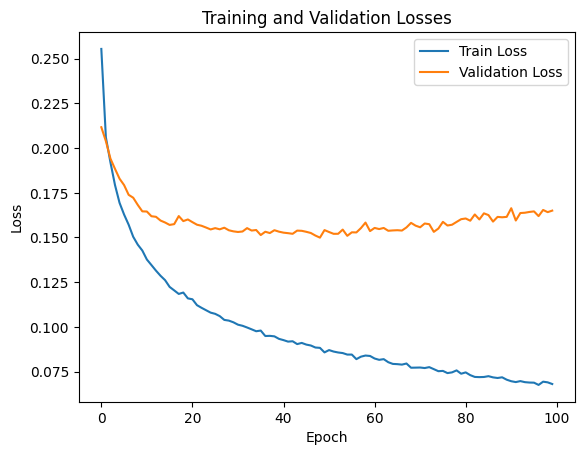

In [36]:
# Plot training and validation losses
plt.figure()
plt.plot(train_losses_gat, label="Train Loss")
plt.plot(val_losses_gat, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Losses")
plt.show()

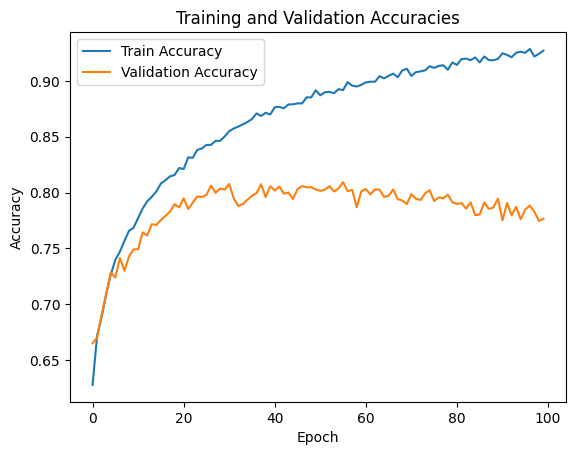

In [37]:
# Plot training and validation accuracies
plt.figure()
plt.plot(train_accuracies_gat, label="Train Accuracy")
plt.plot(val_accuracies_gat, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracies")
plt.show()